In [0]:
import pandas as pd
import datetime as dt
pd.set_option('display.max_columns', 999)
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import math

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def download_file(file_id, file_name):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(file_name)

def upload_file(file_name):
    uploaded = drive.CreateFile({'title': file_name})
    uploaded.SetContentFile(file_name)
    uploaded.Upload()

In [0]:
!unzip "/content/drive/My Drive/Marketing Analytics 1/data.zip"

Archive:  /content/drive/My Drive/Marketing Analytics 1/data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/Data_Dictionary.xlsx  
  inflating: __MACOSX/data/._Data_Dictionary.xlsx  
  inflating: data/new_merchant_transactions.csv  
  inflating: __MACOSX/data/._new_merchant_transactions.csv  
  inflating: data/test.csv           
  inflating: __MACOSX/data/._test.csv  
  inflating: data/merchants.csv      
  inflating: __MACOSX/data/._merchants.csv  
  inflating: data/historical_transactions.csv  
  inflating: __MACOSX/data/._historical_transactions.csv  
  inflating: data/train.csv          
  inflating: __MACOSX/data/._train.csv  
  inflating: data/sample_submission.csv  
  inflating: __MACOSX/data/._sample_submission.csv  


In [0]:
train = pd.read_csv("/content/data/train.csv",parse_dates=["first_active_month"])
merchant = pd.read_csv("/content/data/merchants.csv")
merchant_hist_trx = pd.read_csv("/content/data/historical_transactions.csv",parse_dates=['purchase_date'])
merchant_trx = pd.read_csv("/content/data/new_merchant_transactions.csv",parse_dates=['purchase_date'])
trx = pd.concat([merchant_hist_trx,merchant_trx],axis=0)
end_date = dt.datetime(2018,5,2,0,0,0)

In [0]:
#### Converting Amount into number
trx['purchase_amount_new'] = np.round(trx['purchase_amount'] / 0.00150265118 + 497.06,8)

In [0]:
#### RFM Cust
rfm_cust = trx.groupby(['card_id']).agg({"card_id":"count",
                                         "purchase_amount_new":["sum",'mean'],
                                         "purchase_date":[lambda x:end_date-x.max(),
                                                          lambda x:end_date-x.min()]})

rfm_cust.columns = ["frequency","monetary","avg_monetary","recency","aon"]
rfm_cust = rfm_cust.reset_index()

rfm_cust = rfm_cust[['card_id','frequency','monetary',"avg_monetary",'recency','aon']]

rfm_cust['recency'] = rfm_cust['recency'].dt.days
rfm_cust['aon'] = rfm_cust['aon'].dt.days

In [0]:
def create_rfma_segment(row):
  return row['recency_bracket']+row['freq_bracket']+row['monetary_bracket']+row['aon_bracket']

def create_rfm_segment(row):
  return row['recency_bracket']+row['freq_bracket']+row['monetary_bracket']

In [0]:
def get_bracket(data,column,output):
  data = rfm_cust.sort_values(column,ascending=False)
  data['rel'] = data[column]/data[column].sum()
  data['rel_c'] = data['rel'].cumsum()
  data[output] = pd.cut(data['rel_c'],5,labels=['5','4','3','2','1'])
  del data['rel']
  del data['rel_c']
  return data

In [0]:
rfm_cust = get_bracket(rfm_cust,'recency','recency_bracket')
rfm_cust = get_bracket(rfm_cust,'frequency','freq_bracket')
rfm_cust = get_bracket(rfm_cust,'monetary','monetary_bracket')
rfm_cust = get_bracket(rfm_cust,'aon','aon_bracket')

rfm_cust['rfma'] = rfm_cust.apply(create_rfma_segment,axis=1)
rfm_cust['rfm'] = rfm_cust.apply(create_rfm_segment,axis=1)

In [0]:
rfm_cust.to_csv('rfm_customer.csv',index=False)

In [0]:
rfm_cust['transactions_per_day'] = rfm_cust['frequency']/rfm_cust['aon']

In [0]:
rfm_cust

NameError: ignored

In [0]:
# print(rfm_cust[rfm_cust['recency_bracket']=='1']['recency'].mean())
# print(rfm_cust[rfm_cust['recency_bracket']=='2']['recency'].mean())
# print(rfm_cust[rfm_cust['recency_bracket']=='3']['recency'].mean())
# print(rfm_cust[rfm_cust['recency_bracket']=='4']['recency'].mean())
# print(rfm_cust[rfm_cust['recency_bracket']=='5']['recency'].mean())
#print(rfm_cust[rfm_cust['recency_bracket']=='1']['recency'].mean())
#print(rfm_cust[rfm_cust['monetary_bracket']=='1']['monetary'].mean())

16.82872164939084
74.66036975060986
135.19150877961522
220.65631889411904
316.37596104561766


In [0]:
# rfm_cust['freq_bracket'] = pd.cut(rfm_cust['frequency'], bins=3,labels=['1','2','3'])
# rfm_cust['monetary_bracket'] = pd.cut(rfm_cust['monetary'], bins=3,labels=['1','2','3'])
# rfm_cust['recency_bracket'] = pd.cut(rfm_cust['recency'], bins=3,labels=['3','2','1'])
# rfm_cust['aon_bracket'] = pd.cut(rfm_cust['aon'], bins=3,labels=['1','2','3'])
# rfm_cust['rfma'] = rfm_cust.apply(create_rfma_segment,axis=1)
# rfm_cust['rfm'] = rfm_cust.apply(create_rfm_segment,axis=1)

In [0]:
scaler = StandardScaler()
scaler.fit(rfm_cust[['recency','frequency','monetary']])
rfm_cust_arr_scaled = scaler.transform(rfm_cust[['recency','frequency','monetary']])

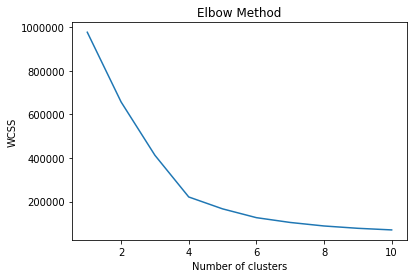

In [0]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_cust_arr_scaled)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [0]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(rfm_cust_arr_scaled)

In [0]:
rfm_cust_segments = rfm_cust.copy()
rfm_cust_segments['segments'] = pred_y

In [0]:
scaler.inverse_transform(kmeans.cluster_centers_)

array([[3.27673096e+01, 6.81581057e+01, 2.69072550e+04],
       [2.30424805e+01, 3.39999650e+02, 1.05923445e+05],
       [2.22671386e+02, 5.83269896e+01, 2.61192305e+04],
       [2.31000000e+02, 1.90000000e+01, 4.00000055e+09]])

In [0]:
rfm_cust['freq_bracket1'] = pd.cut(rfm_cust['frequency'], bins=3)
rfm_cust['monetary_bracket1'] = pd.cut(rfm_cust['monetary'], bins=3)
rfm_cust['recency_bracket1'] = pd.cut(rfm_cust['recency'], bins=3)

In [0]:
pd.cut(rfm_cust['monetary'], bins=5)


0         (-3999994.571, 800000114.222]
1         (-3999994.571, 800000114.222]
2         (-3999994.571, 800000114.222]
3         (-3999994.571, 800000114.222]
4         (-3999994.571, 800000114.222]
                      ...              
325535    (-3999994.571, 800000114.222]
325536    (-3999994.571, 800000114.222]
325537    (-3999994.571, 800000114.222]
325538    (-3999994.571, 800000114.222]
325539    (-3999994.571, 800000114.222]
Name: monetary, Length: 325540, dtype: category
Categories (5, interval[float64]): [(-3999994.571, 800000114.222] < (800000114.222, 1600000222.473] <
                                    (1600000222.473, 2400000330.725] < (2400000330.725, 3200000438.977] <
                                    (3200000438.977, 4000000547.228]]

In [0]:
rfm_cust[rfm_cust['rfm']=='111'].describe()

,frequency,monetary,avg_monetary,recency,aon
count,289125.000000,2.891250e+05,2.891250e+05,289125.000000,289125.000000
mean,99.225999,3.627150e+04,4.385603e+02,33.953415,339.504761
std,110.170508,9.430773e+05,1.945910e+04,35.726257,120.057696
min,2.000000,1.060000e+01,1.546501e+00,0.000000,120.000000
25%,32.000000,2.640580e+03,4.680778e+01,5.000000,230.000000
50%,63.000000,5.754220e+03,8.590759e+01,20.000000,347.000000
75%,123.000000,1.288668e+04,1.658920e+02,54.000000,467.000000
max,1786.000000,1.100148e+08,6.406137e+06,151.000000,484.000000


In [0]:
rfm_cust[rfm_cust['rfm']=='211'].describe()

,frequency,monetary,avg_monetary,recency,aon
count,28924.000000,2.892400e+04,2.892400e+04,28924.000000,28924.000000
mean,69.245229,2.908554e+04,5.652139e+02,214.060538,437.156272
std,73.083717,8.518868e+05,2.213434e+04,43.057581,56.439756
min,2.000000,1.432001e+01,1.022858e+00,152.000000,181.000000
25%,24.000000,1.737815e+03,4.135075e+01,178.000000,408.000000
50%,46.000000,3.745995e+03,7.488665e+01,212.000000,464.000000
75%,87.000000,8.114473e+03,1.436514e+02,248.000000,480.000000
max,951.000000,9.200407e+07,2.445118e+06,302.000000,484.000000


In [0]:
rfm_cust[rfm_cust['rfm']=='311'].describe()

,frequency,monetary,avg_monetary,recency,aon
count,289125.000000,2.891250e+05,2.891250e+05,289125.000000,289125.000000
mean,99.225999,3.627150e+04,4.385603e+02,33.953415,339.504761
std,110.170508,9.430773e+05,1.945910e+04,35.726257,120.057696
min,2.000000,1.060000e+01,1.546501e+00,0.000000,120.000000
25%,32.000000,2.640580e+03,4.680778e+01,5.000000,230.000000
50%,63.000000,5.754220e+03,8.590759e+01,20.000000,347.000000
75%,123.000000,1.288668e+04,1.658920e+02,54.000000,467.000000
max,1786.000000,1.100148e+08,6.406137e+06,151.000000,484.000000


In [0]:
rfm_cust[rfm_cust['rfm']=='321'].describe()

,frequency,monetary,avg_monetary,recency,aon
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,2393.000000,186763.826173,84.770306,48.000000,481.333333
std,456.029604,122129.208929,59.664714,60.008333,3.055050
min,2072.000000,58301.318104,20.000452,8.000000,478.000000
25%,2132.000000,129456.029294,58.410154,13.500000,480.000000
50%,2192.000000,200610.740484,96.819855,19.000000,482.000000
75%,2553.500000,250995.080207,117.155233,68.000000,483.000000
max,2915.000000,301379.419929,137.490611,117.000000,484.000000


In [0]:
rfm_cust[rfm_cust['rfm']=='331'].describe()

,frequency,monetary,avg_monetary,recency,aon
count,1.0,1.000000,1.000000,1.0,1.0
mean,5582.0,381919.737406,68.419874,151.0,437.0
std,NaN,NaN,NaN,NaN,NaN
min,5582.0,381919.737406,68.419874,151.0,437.0
25%,5582.0,381919.737406,68.419874,151.0,437.0
50%,5582.0,381919.737406,68.419874,151.0,437.0
75%,5582.0,381919.737406,68.419874,151.0,437.0
max,5582.0,381919.737406,68.419874,151.0,437.0


In [0]:
rfm_cust[rfm_cust['rfm']=='213'].describe()

,frequency,monetary,avg_monetary,recency,aon
count,1.0,1.000000e+00,1.000000e+00,1.0,1.0
mean,19.0,4.000001e+09,2.105263e+08,231.0,372.0
std,NaN,NaN,NaN,NaN,NaN
min,19.0,4.000001e+09,2.105263e+08,231.0,372.0
25%,19.0,4.000001e+09,2.105263e+08,231.0,372.0
50%,19.0,4.000001e+09,2.105263e+08,231.0,372.0
75%,19.0,4.000001e+09,2.105263e+08,231.0,372.0
max,19.0,4.000001e+09,2.105263e+08,231.0,372.0
